In [21]:
#library(tidyverse)
library("dplyr") 
library(caTools) # Prediction: Splitting Data
library(car)
library(ROCR)
library(e1071) # Prediction: SVM, Naive Bayes, Parameter Tuning
library(rpart) # Prediction: Decision Tree
library(rpart.plot) # Prediction: Decision Tree
library(caret) # Prediction: k-Fold Cross Validation
library(xgboost) # for xgboost
library(reshape)
library(ggplot2)


In this notebook we will go over following steps:-

- Reduce the amount of redundant information
- Convert categorical information to a numeric format
- Split dataset into testing and training subsets
- Convert the cleaned dataframe to a Dmatrix
- Model Training & Validation

In [5]:
df <- read.csv('Kickstarter_Clean_Final.csv')
message('Rows: ',dim(df)[1],'---Columns: ',dim(df)[2])

Rows: 75178---Columns: 23


## Drop Columns

Reduce the amount of redundant information

In [7]:
cols_to_drop<-c('converted_pledged_amount_USD',
'country',
'currency',
'pledged',
'backers_count',
'usd_exchange_rate',
'usd_type',
'goal_converted',
'ctgy_name')

df1<-df[ , !(names(df) %in% cols_to_drop)]
message('Rows: ',dim(df1)[1],'---Columns: ',dim(df1)[2])

Rows: 75178---Columns: 14


## Fixing Target Variable

In [8]:
df1 <- df1 %>%
  mutate(state = case_when(state=="failed" ~ 1, 
                              state=="successful" ~ 0))

## Converting Ctgy features to numerical

Some of our categorical features may include helpful information, such as staff_pick. Let's try to perserve some of these variables for our XGBoost model by converting them to the class numeric.

The function model.matrix() performs one-hot encoding of categorical data and creates a sparse matrix. A value of 1 indicates that the variable is present for an observation. The first argument is the variable; the second is the dataframe. The reason we include a minus 1 after the variable is to prevent the first column from becoming the Intercept.

In [9]:
head(staff_pick<-model.matrix(~ staff_pick-1, df1))
head(launch_day<-model.matrix(~ launch_day-1, df1))

head(launch_month<-model.matrix(~ launch_month-1, df1))
head(launch_year<-model.matrix(~ launch_year-1, df1))

head(lc_name<-model.matrix(~ lc_name-1, df1))
head(lc_state<-model.matrix(~ lc_state-1, df1))

head(lc_expanded_country<-model.matrix(~ lc_expanded_country-1, df1))
head(ctgy_parent_name<-model.matrix(~ ctgy_parent_name-1, df1))

staff_pickFalse,staff_pickTrue
1,0
0,1
1,0
0,1
1,0
0,1


launch_dayFriday,launch_dayMonday,launch_daySaturday,launch_daySunday,launch_dayThursday,launch_dayTuesday,launch_dayWednesday
0,0,1,0,0,0,0
0,0,0,0,1,0,0
0,0,0,0,1,0,0
0,0,0,0,1,0,0
0,0,0,0,0,0,1
0,0,0,0,0,0,1


launch_month
2
2
2
2
2
2


launch_year
2018
2018
2018
2018
2018
2018


lc_nameChicago,lc_nameLondon,lc_nameLos Angeles,lc_nameNew York,lc_nameOther
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1


lc_stateCA,lc_stateEngland,lc_stateNY,lc_stateOther
0,0,0,1
0,0,1,0
0,0,0,1
0,0,0,1
0,0,0,1
0,0,0,1


lc_expanded_countryAustralia,lc_expanded_countryCanada,lc_expanded_countryOther,lc_expanded_countryUnited Kingdom,lc_expanded_countryUnited States
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
1,0,0,0,0
0,0,0,0,1
0,0,1,0,0


ctgy_parent_nameArt,ctgy_parent_nameComics,ctgy_parent_nameCrafts,ctgy_parent_nameDance,ctgy_parent_nameDesign,ctgy_parent_nameFashion,ctgy_parent_nameFilm & Video,ctgy_parent_nameFood,ctgy_parent_nameGames,ctgy_parent_nameJournalism,ctgy_parent_nameMusic,ctgy_parent_namePhotography,ctgy_parent_namePublishing,ctgy_parent_nameTechnology,ctgy_parent_nameTheater
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_ctgy_num <- cbind(staff_pick, launch_day, lc_name, lc_state, lc_expanded_country, ctgy_parent_name)
head(df_ctgy_num)

staff_pickFalse,staff_pickTrue,launch_dayFriday,launch_dayMonday,launch_daySaturday,launch_daySunday,launch_dayThursday,launch_dayTuesday,launch_dayWednesday,lc_nameChicago,...,ctgy_parent_nameFashion,ctgy_parent_nameFilm & Video,ctgy_parent_nameFood,ctgy_parent_nameGames,ctgy_parent_nameJournalism,ctgy_parent_nameMusic,ctgy_parent_namePhotography,ctgy_parent_namePublishing,ctgy_parent_nameTechnology,ctgy_parent_nameTheater
1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
select_num <- c('goal','launch_month','launch_hour','launch_year','campaignDuration','daysToLaunch','price','state')
head(df1[select_num])

goal,launch_month,launch_hour,launch_year,campaignDuration,daysToLaunch,price,state
1500,2,13,2018,31,28,26.73,0
8000,2,22,2018,44,2,76.15,0
2000,2,20,2018,59,165,35.18,0
2500,2,11,2018,27,112,40.70,0
7000,2,13,2018,32,146,111.38,0
7000,2,6,2018,20,20,10.76,0


In [13]:
df2<-cbind(df1[select_num],data.frame(df_ctgy_num))
head(df2)

goal,launch_month,launch_hour,launch_year,campaignDuration,daysToLaunch,price,state,staff_pickFalse,staff_pickTrue,...,ctgy_parent_nameFashion,ctgy_parent_nameFilm...Video,ctgy_parent_nameFood,ctgy_parent_nameGames,ctgy_parent_nameJournalism,ctgy_parent_nameMusic,ctgy_parent_namePhotography,ctgy_parent_namePublishing,ctgy_parent_nameTechnology,ctgy_parent_nameTheater
1500,2,13,2018,31,28,26.73,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8000,2,22,2018,44,2,76.15,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2000,2,20,2018,59,165,35.18,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2500,2,11,2018,27,112,40.70,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7000,2,13,2018,32,146,111.38,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7000,2,6,2018,20,20,10.76,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#goal,launch_month,launch_hour,launch_year,campaignDuration,daysToLaunch,

## Splitting data

- Train : 80 %
- Test : 20 %

In [15]:
set.seed(500)
split = sample.split(df2$state, SplitRatio = 0.8)
train = subset(df2, split == TRUE)
test = subset(df2, split == FALSE)

In [16]:
message("Train Rows=",dim(train)[1],'---Columns=',dim(train)[2])
message("Test Rows=",dim(test)[1],'---Columns=',dim(test)[2])

Train Rows=60142---Columns=46
Test Rows=15036---Columns=46


## XGB Model

Gradient boosting is part of a class of machine learning techniques known as ensemble methods. An ensemble method leverages the output of many weak learners in order to make a prediction. Typically, these weak learners are implemented as decision trees. While each individual weak learner might not get the answer right, on average, their combined answers should be pretty decent.

In gradient boosting, each weak learner is chosen iteratively in a greedy manner, so as to minimize the loss function. **XGBoost is a highly optimized implementation of gradient boosting**. 

In [18]:
y_train  <-train$state
#length(y_train)

y_test <- test$state
#length(y_test)


cols_to_drop<-c('state')

X_train<-train[ , !(names(train) %in% cols_to_drop)]
#dim(X_train)
message('X_train Rows: ',dim(X_train)[1],'---X_train Columns: ',dim(X_train)[2])

cols_to_drop<-c('state')

X_test<-test[ , !(names(test) %in% cols_to_drop)]
message('X_test Rows: ',dim(X_test)[1],'---X_test Columns: ',dim(X_test)[2])


X_train Rows: 60142---X_train Columns: 45
X_test Rows: 15036---X_test Columns: 45


- XGBoost algorithm takes a matrix as input.
- Convert Dataframe to Dmatrix

In [26]:
# convert your matrix into a Dmatrix
dtrain <- xgb.DMatrix(data = as.matrix(X_train),label = y_train)
dtest <- xgb.DMatrix(data = as.matrix(X_test),label = y_test)

## Model Training

- The first argument of xgboost() takes a Dmatrix object.

- The second argument, nround, is the number of times we want to improve--or boost--our naive model by adding additional error models.

- Since its a binary Classification, we will specify the third argument as logistic regression for binary classification.

In [27]:
# fit a model to your horse matrix
xgb_model <- xgboost(data = dtrain, # Dmatrix of data
                       nround = 2, # boosting iterations
                       objective = "binary:logistic")

[11:01:24] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-logloss:0.525013 
[2]	train-logloss:0.431866 


## Training Accuracy / Metrics

In [28]:

prob_pred = predict(xgb_model, newdata = dtrain)
y_pred = ifelse(prob_pred > 0.5, 1, 0)

# Checking the prediction accuracy
table(y_train, y_pred > 0.5) # Confusion matrix

       
y_train FALSE  TRUE
      0 43519  1053
      1  5409 10161

In [29]:
err <- mean(as.numeric(prob_pred > 0.5) != y_train)
print(paste("train-error=", err))

[1] "train-error= 0.10744571181537"


In [30]:
message("Accuracy= ",round(((43519+10161)/dim(train)[1])*100,2),' %')


Accuracy= 89.26 %


In [31]:
confusionMatrix(factor(y_pred),factor(y_train),mode = "everything", positive="1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 43519  5409
         1  1053 10161
                                         
               Accuracy : 0.8926         
                 95% CI : (0.8901, 0.895)
    No Information Rate : 0.7411         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.692          
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.6526         
            Specificity : 0.9764         
         Pos Pred Value : 0.9061         
         Neg Pred Value : 0.8894         
              Precision : 0.9061         
                 Recall : 0.6526         
                     F1 : 0.7587         
             Prevalence : 0.2589         
         Detection Rate : 0.1690         
   Detection Prevalence : 0.1865         
      Balanced Accuracy : 0.8145      

In [32]:
message("Train F1 Score: ",0.75)

Train F1 Score: 0.75


## Hyperparameter Tuning + Cross Validation + Early Stopping

### Crossvalidation

10 fold cross validation with xgb.cv


### Hyperparameter Tuning


Parameters for Tree Booster
- **nrounds[default=100]**
    It controls the maximum number of iterations. For classification, it is similar to the number of trees to grow.
- **eta[default=0.3][range: (0,1)]**
    It controls the learning rate, i.e., the rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.

- **gamma[default=0][range: (0,Inf)]**
    It controls regularization (or prevents overfitting). The optimal value of gamma depends on the data set and other parameter values.
- **max_depth[default=6][range: (0,Inf)]**
    It controls the depth of the tree.

- **min_child_weight[default=1][range:(0,Inf)]**
    In classification, if the leaf node has a minimum sum of instance weight (calculated by second order partial derivative) lower than min_child_weight, the tree splitting stops.

- **subsample[default=1][range: (0,1)]**
    It controls the number of samples (observations) supplied to a tree.

- **colsample_bytree[default=1][range: (0,1)]**
    It control the number of features (variables) supplied to a tree


In [33]:
params <- list(booster = "gbtree", 
               objective = "binary:logistic", 
               eta=0.3, 
               gamma=0, 
               max_depth=6, 
               min_child_weight=1, 
               subsample=1, 
               colsample_bytree=1)


xgbcv <- xgb.cv( params = params, 
                data = dtrain, 
                nrounds = 100, 
                nfold = 10, 
                #metrics='aucpr',
                eval_metric='aucpr',
                showsd = T, 
                stratified = T, 
                early_stopping_rounds = 10, 
                maximize = T
               )

[1]	train-aucpr:0.839960+0.001343	test-aucpr:0.836197+0.005185 
Multiple eval metrics are present. Will use test_aucpr for early stopping.
Will train until test_aucpr hasn't improved in 10 rounds.

[2]	train-aucpr:0.866693+0.000943	test-aucpr:0.862319+0.004404 
[3]	train-aucpr:0.879597+0.002192	test-aucpr:0.874592+0.004287 
[4]	train-aucpr:0.893161+0.001901	test-aucpr:0.887725+0.005180 
[5]	train-aucpr:0.899371+0.002058	test-aucpr:0.893522+0.005045 
[6]	train-aucpr:0.904349+0.001959	test-aucpr:0.898035+0.004641 
[7]	train-aucpr:0.907712+0.001189	test-aucpr:0.900669+0.003811 
[8]	train-aucpr:0.910667+0.001820	test-aucpr:0.903773+0.003861 
[9]	train-aucpr:0.913246+0.001220	test-aucpr:0.906370+0.003330 
[10]	train-aucpr:0.916639+0.000857	test-aucpr:0.909503+0.003716 
[11]	train-aucpr:0.919632+0.000730	test-aucpr:0.912172+0.003864 
[12]	train-aucpr:0.921886+0.000938	test-aucpr:0.914173+0.004055 
[13]	train-aucpr:0.924051+0.001162	test-aucpr:0.915897+0.003903 
[14]	train-aucpr:0.925938+0.00

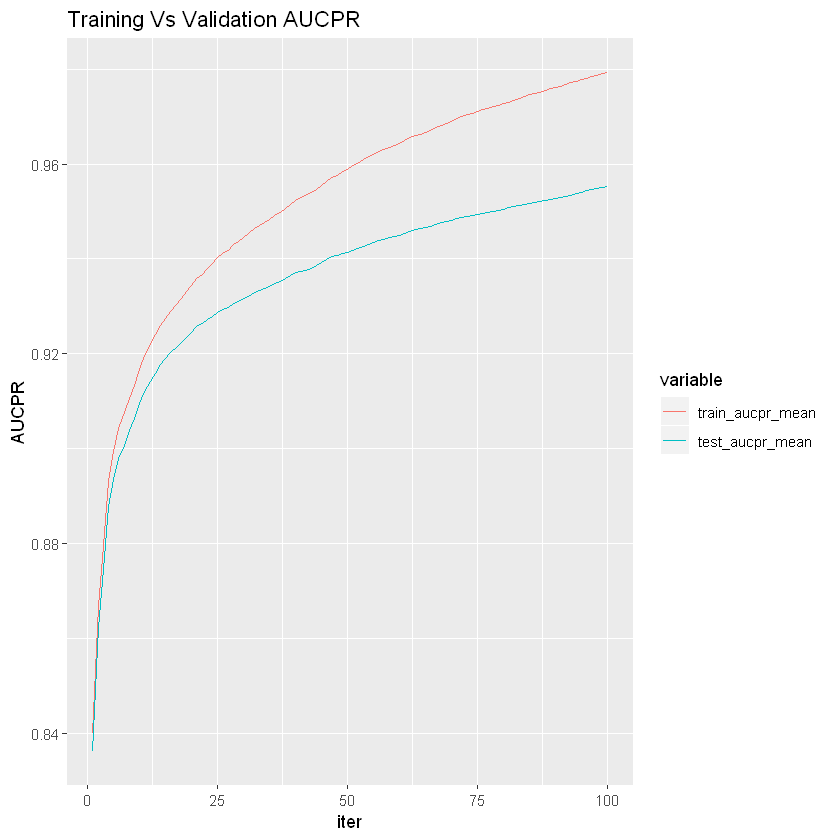

In [35]:
xgbcv_aucpr<-xgbcv$evaluation_log %>%
  select(iter,train_aucpr_mean,test_aucpr_mean)
# Long format
g2 <- melt(xgbcv_aucpr, id.vars = c("iter"))
ggplot(g2, aes(x = iter, y = value, color = variable)) +
    ggtitle("Training Vs Validation AUCPR") +
  geom_line()+ylab("AUCPR")

## Test

In [36]:
xgb1 <- xgb.train (params = params, 
                   data = dtrain, 
                   nrounds = 100, 
                   watchlist = list(val=dtest,train=dtrain), 
                   early_stopping_rounds= 10, 
                   maximize = F , 
                   eval_metric = "aucpr")
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.5,1,0)

[1]	val-aucpr:0.832491	train-aucpr:0.840309 
Multiple eval metrics are present. Will use train_aucpr for early stopping.
Will train until train_aucpr hasn't improved in 10 rounds.

[2]	val-aucpr:0.857362	train-aucpr:0.866145 
[3]	val-aucpr:0.870280	train-aucpr:0.879727 
[4]	val-aucpr:0.881770	train-aucpr:0.892849 
[5]	val-aucpr:0.888751	train-aucpr:0.897319 
[6]	val-aucpr:0.892996	train-aucpr:0.902137 
[7]	val-aucpr:0.895384	train-aucpr:0.905730 
[8]	val-aucpr:0.898901	train-aucpr:0.909456 
[9]	val-aucpr:0.904745	train-aucpr:0.915163 
[10]	val-aucpr:0.908042	train-aucpr:0.918544 
[11]	val-aucpr:0.908869	train-aucpr:0.919910 
Stopping. Best iteration:
[1]	val-aucpr:0.832491	train-aucpr:0.840309



In [37]:
confusionMatrix(factor(xgbpred),factor(y_test),mode = "everything", positive="1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10735  1263
         1   408  2630
                                          
               Accuracy : 0.8889          
                 95% CI : (0.8837, 0.8938)
    No Information Rate : 0.7411          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6881          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6756          
            Specificity : 0.9634          
         Pos Pred Value : 0.8657          
         Neg Pred Value : 0.8947          
              Precision : 0.8657          
                 Recall : 0.6756          
                     F1 : 0.7589          
             Prevalence : 0.2589          
         Detection Rate : 0.1749          
   Detection Prevalence : 0.2020          
      Balanced Acc

In [38]:
message("Best F1 Score for Test:", 0.75)

Best F1 Score for Test:0.75


## Variable Importance

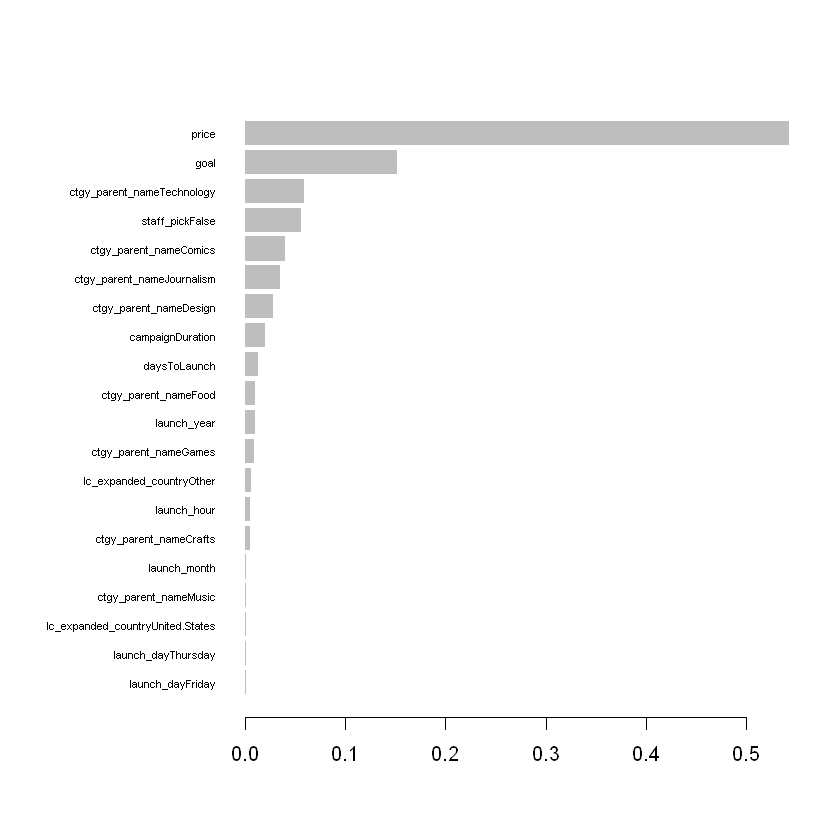

In [39]:
mat <- xgb.importance (feature_names = colnames(X_train),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20]) 